# OTF and PSF Construction Developement Notebook

In [1]:
%pylab inline
from pyfftw.interfaces.numpy_fft import *
from pyfftw.interfaces import cache
cache.enable()

from dphplotting import slice_plot, mip
from dphutils import scale

Populating the interactive namespace from numpy and matplotlib


In [2]:
class NumericProperty(property):
    """A property that must be numeric.

    Parameters
    ----------
    attr : str
        The name of the backing attribute.
    vartype : type
        The type to validate, defaults to `int`
    doc : str
        Docstring for the parameter

    """

    def __init__(self, fget=None, fset=None, fdel=None, doc=None, attr=None, vartype=None):
        if attr is not None and vartype is not None:
            self.attr = attr
            self.vartype = vartype
            def fget(obj):
                return getattr(obj, self.attr)

            def fset(obj, value):
                if not isinstance(value, self.vartype):
                    raise TypeError("{} must be an {}, var = {!r}".format(self.attr, self.vartype, value))
                if value <= 0:
                    raise ValueError("{} must be larger than 0".format(self.attr))
                if getattr(obj, self.attr, None) != value:
                    setattr(obj, self.attr, value)
                    # call update code
                    obj._attribute_changed()
        super().__init__(fget, fset, fdel, doc)

In [3]:
class BasePSF(object):
    """A base class for objects that can calculate OTF's and PSF's. It is not intended to be used alone"""

    wl = NumericProperty(attr="_wl", vartype=(float, int), doc="Wavelength of emission, in nm")
    na = NumericProperty(attr="_na", vartype=(float, int), doc="Numerical Aperature")
    ni = NumericProperty(attr="_ni", vartype=(float, int), doc="Refractive index")
    size = NumericProperty(attr="_size", vartype=int, doc="x/y size")
    zsize = NumericProperty(attr="_zsize", vartype=int, doc="z size")
    
    def __init__(self, wl, na, ni, res, size, zres=None, zsize=None, vec_corr="none"):
        """Generate a PSF object
        To fully describe a PSF or OTF of an objective lens, assuming no abberation, we generally need a few parameters:
        - The wavelength of operation (assume monochromatic light)
        - the numerical aperature of the objective
        - the index of refraction of the medium
        
        For numerical calculations we'll also want to know the x/y resolution and number of points.
        """
        self.wl = wl
        self.na = na
        self.ni = ni
        self.res = res
        self.size = size
        if zres is None:
            zres = res
        self.zres = zres
        if zsize is None:
            zsize = size
        self.zsize = zsize
        self.vec_corr = vec_corr
    
    def _attribute_changed(self):
        """called whenever key attributes are changed"""
        # update internals that depend on this
        raise NotImplementedError
        
    def _gen_psf(self):
        """Generate the PSF"""
        raise NotImplementedError

    def _gen_otf(self):
        """Generate the OTF"""
        raise NotImplementedError
    
    @property
    def zres(self):
        """z resolution, nm"""
        return self._zres
    
    @zres.setter
    def zres(self, value):
        max_val = 1/(2 * self.ni/self.wl)
        if value >= max_val:
            raise ValueError("{!r} is too large try a number smaller than {!r}".format(value, max_val))
        self._zres = value
        self._attribute_changed()
        
    @property
    def res(self):
        """x/y resolution, nm"""
        return self._res
    
    @res.setter
    def res(self, value):
        max_val = 1/(2 * self.na/self.wl) / 2
        if value >= max_val:
            raise ValueError("{!r} is too large try a number smaller than {!r}".format(value, max_val))
        self._res = value
        self._attribute_changed()
        
    @property
    def vec_corr(self):
        """Whether to apply a correction to take into account the vectorial nature of light
        
        Valid values are:
        none
        x
        y
        z
        total"""
        return self._vec_corr
    
    @vec_corr.setter
    def vec_corr(self, value):
        if value in {"none", "x", "y", "z", "total"}:
            self._vec_corr = value
            self._attribute_changed()
        else:
            raise ValueError("{!r} is not a valid vector correction".format(value))
        
    @property
    def OTFi(self):
        """Intensity OTF"""
        raise NotImplementedError
    
    @property
    def OTFa(self):
        """Amplitude OTF, complex"""
        raise NotImplementedError
    
    @property
    def PSFi(self):
        """Intensity PSF"""
        raise NotImplementedError
    
    @property
    def PSFa(self):
        """Amplitude PSF, complex"""
        raise NotImplementedError

In [4]:
def easy_fft(data, axes=None):
    """utility method that includes shifting"""
    return ifftshift(
        fftn(
            fftshift(
                data, axes=axes
            ), axes=axes
        ), axes=axes)

def easy_ifft(data, axes=None):
    """utility method that includes shifting"""
    return fftshift(
        ifftn(
            ifftshift(
                data, axes=axes
            ), axes=axes
        ), axes=axes)

def cart2pol(y, x):
    """utility function for converting from cartesian to polar"""
    theta = np.arctan2(y, x)
    rho = np.hypot(y, x)
    return rho, theta

In [5]:
class HanserPSF(BasePSF):
    """
    A class defining the pupil function and its closely related methods.
    
    Based on the following work

    [(1) Hanser, B. M.; Gustafsson, M. G. L.; Agard, D. A.; Sedat, J. W.
    Phase-Retrieved Pupil Functions in Wide-Field Fluorescence Microscopy.
    Journal of Microscopy 2004, 216 (1), 32–48.](dx.doi.org/10.1111/j.0022-2720.2004.01393.x)
    """
    def __init__(self, *args, zrange=None, **kwargs):
        """See BasePSF for more details""" 
        super().__init__(*args, **kwargs)
        if zrange is None:
            self._gen_zrange()
        else:
            self.zrange = zrange
    
    def _gen_zrange(self):
        self.zrange = (np.arange(self.zsize) - self.zsize / 2) * self.zres
    
    @BasePSF.zsize.setter
    def zsize(self, value):
        BasePSF.zsize.fset(self, value)
        try:
            self._gen_zrange()
        except AttributeError:
            pass
        
    @BasePSF.zres.setter
    def zres(self, value):
        BasePSF.zres.fset(self, value)
        try:
            self._gen_zrange()
        except AttributeError:
            pass
    
    @property
    def zrange(self):
        """The range overwhich to calculate the psf"""
        return self._zrange
    
    @zrange.setter
    def zrange(self, value):
        self._zrange = np.asarray(value)
        if not self._zrange.shape:
            self._zrange.shape = (1, )
        self._attribute_changed()
    
    def _attribute_changed(self):
        """called whenever key attributes are changed"""
        # set the PSFs to None so they get recalculated
        self._PSFi = None
        self._PSFa = None
        self._OTFi = None
        self._OTFa = None
        
    def _gen_kr(self):
        # we"re generating complex data in k-space which means the total
        # bandwidth is k_max, but the positive max is half that
        k = fftfreq(self.size, self.res)
        kxx, kyy = np.meshgrid(k, k)
        self._kr, self._phi = cart2pol(kyy, kxx)
        self._kmag = self.ni/self.wl
        self._kz = np.real(np.sqrt((self._kmag**2 - self._kr**2).astype(complex)))

    def _gen_pupil(self):
        """Generate ideal pupil function"""
        kr = self._kr

        # define the diffraction limit
        # remember we"re working with _coherent_ data _not_ intensity,
        # so drop the factor of 2
        diff_limit = self._na/self._wl

        # return a circle of intensity 1 over the ideal passband of the
        # objective make sure data is complex
        return (kr < diff_limit).astype(complex)
    
    def calc_defocus(self):
        """Apply defocus to the base pupil"""
        kr = self._kr
        # pull the azimuthal angle
        phi = self._phi
        kz = self._kz        
        return np.exp(2 * np.pi * 1j * kz * self.zrange[:, newaxis, newaxis])
    
    def _gen_psf(self, pupil_base=None):
        """A function that generates a point spread function over the desired
        `zrange` from the given pupil

        It is assumed that the `pupil` has indices ordered as (y, x) to be
        consistent with image data conventions

        Parameters
        ---
        zrange

        Returns
        ---
        3D PSF"""
        # generate internal state
        self._gen_kr()
        # generate the pupil
        if pupil_base is None:
            pupil_base = self._gen_pupil()
        # generate the kr
        kr = self._kr
        # pull the azimuthal angle
        phi = self._phi
        kmag = self._kmag
        my_kz = self._kz
        pupil = pupil_base * self.calc_defocus()
        
        if self.vec_corr != "none":
            # no need to calculate all of these
            theta = np.arcsin((kr < kmag) * kr / kmag)  # Incident angle
            # The authors claim that the following line is unecessary as this
            # factor is already included in the definition of the pupil function
            # pupil /= sqrt(cos(theta))
            plist = []
            if self.vec_corr == "z" or self.vec_corr == "total":
                plist.append(np.sin(theta) * np.cos(phi))  # Pzx
                plist.append(np.sin(theta) * np.sin(phi))  # Pzy
            if self.vec_corr == "y" or self.vec_corr == "total":
                plist.append((np.cos(theta)-1) * np.sin(phi) * np.cos(phi))  # Pyx
                plist.append(np.cos(theta) * np.sin(phi)**2 + np.cos(phi)**2)  # Pyy
            if self.vec_corr == "x" or self.vec_corr == "total":
                plist.append(np.cos(theta) * np.cos(phi)**2 + np.sin(phi)**2)  # Pxx
                plist.append((np.cos(theta)-1) * np.sin(phi) * np.cos(phi))  # Pxy
            pupils = pupil * np.array(plist)[:, newaxis]
        else:
            pupils = pupil[newaxis]
        self.pupil = pupil
        PSFa = ifftshift(fftn(pupils, axes=(2, 3)), axes=(2, 3))

        PSFi_sub = abs(PSFa)**2

        PSFi = PSFi_sub.sum(axis=0)
        
        self._PSFi = PSFi
        self._PSFa = PSFa
        
    @property
    def OTFa(self):
        if self._OTFa is None:
            self._OTFa =easy_fft(self.PSFa, axes=(1, 2, 3))
        return self._OTFa
    
    @property
    def PSFa(self):
        if self._PSFa is None:
            self._gen_psf()
        return self._PSFa
    
    @property
    def PSFi(self):
        if self._PSFi is None:
            self._gen_psf()
        return self._PSFi
    
    @property
    def OTFi(self):
        if self._OTFi is None:
            self._OTFi = ifftshift(fftn(fftshift(self.PSFi)))
        return self._OTFi

In [6]:
psf = HanserPSF(520, 0.85, 1.0, 130, 256, zrange = (np.arange(26)-25/2) * 400)

(<matplotlib.figure.Figure at 0x20b93e599b0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020B980FACF8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000020B980FA320>], dtype=object))

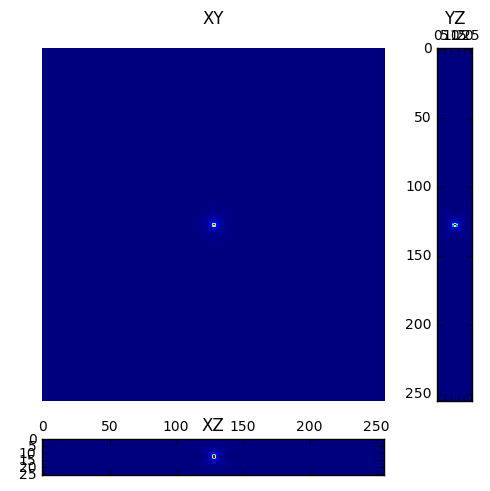

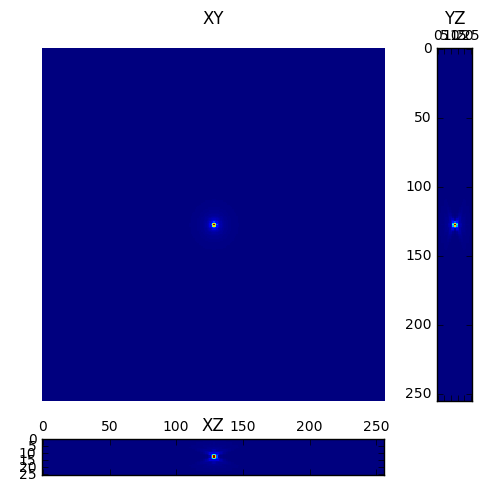

In [7]:
psf.size=256
psf.vec_corr = "none"
# psf.zrange = linspace(-3000,3000,26)
PSFi, PSFa = psf.PSFi, psf.PSFa
mip(PSFi)
psf.vec_corr = "total"
PSFi_all, PSFa_all = psf.PSFi, psf.PSFa
mip(PSFi_all)

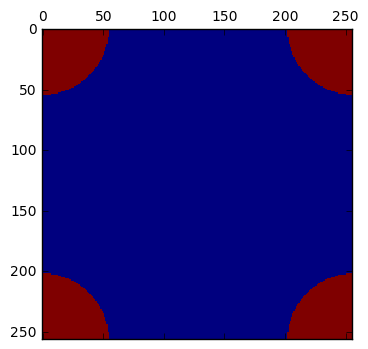

In [8]:
matshow(abs(psf._gen_pupil()))

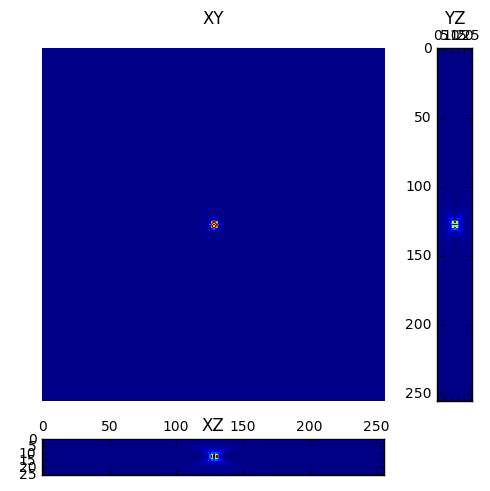

In [9]:
fig, ax = slice_plot(scale(PSFi_all)-scale(PSFi))

In [23]:
psf.zres = psf.res
psf.zsize = psf.size
slice_plot(log(scale(abs(psf.OTFi))), vmin=-9)

AttributeError: 'list' object has no attribute 'res'

In [11]:
class SheppardPSF(BasePSF):
    """
    A class defining the pupil function and its closely related methods.
    
    Based on the following work

    [(1) Hanser, B. M.; Gustafsson, M. G. L.; Agard, D. A.; Sedat, J. W.
    Phase-Retrieved Pupil Functions in Wide-Field Fluorescence Microscopy.
    Journal of Microscopy 2004, 216 (1), 32–48.](dx.doi.org/10.1111/j.0022-2720.2004.01393.x)
    """
    def __init__(self, *args, **kwargs):
        """See BasePSF for more details""" 
        super().__init__(*args, **kwargs)
        self.coherent = False
        self.condition = "sine"
        self._attribute_changed()
    
    def _attribute_changed(self):
        """called whenever key attributes are changed"""
        # update internals that depend on this
        self._PSFi = None
        self._PSFa = None
        self._OTFi = None
        self._OTFa = None
        
    def _gen_kr(self):
        # we"re generating complex data in k-space which means the total
        # bandwidth is k_max, but the positive max is half that
        k = fftfreq(self.size, self.res)
        kz = fftfreq(self.zsize, self.zres)
        k_tot = np.meshgrid(kz, k, k, indexing="ij")
        kr = norm(k_tot, axis=0)
        self.kmag = kmag = self.ni/self.wl
        dk, dkz = k[1] - k[0], kz[1] - kz[0]
        kz_min = sqrt(kmag ** 2 - (self.na / self.wl) ** 2)
        assert kz_min >= 0
        if dk != dkz:
            with np.errstate(invalid='ignore'):
                dkr = norm(np.array(k_tot) * array((dkz, dk, dk)).reshape(3, 1, 1, 1), axis=0)/kr
            # we know the origin is zero so replace it
            dkr[0, 0, 0] = 0.0
        else:
            dkr = dk
        if self.coherent:
            kzz = abs(k_tot[0])
        else:
            kzz = k_tot[0]
        self.valid_points = np.logical_and(abs(kr - kmag) < dkr, kzz > kz_min + dkr)
        self.kzz, self.kyy, self.kxx = [k[self.valid_points] for k in k_tot]
        self.s = nan_to_num(sqrt(kmag ** 2 - self.kxx ** 2 - self.kyy ** 2))
        
    
    def _gen_otf(self):
        """A function that generates a point spread function over the desired
        `zrange` from the given pupil

        It is assumed that the `pupil` has indices ordered as (y, x) to be
        consistent with image data conventions

        Parameters
        ---
        zrange

        Returns
        ---
        3D PSF"""
        self._gen_kr()
        kxx, kyy, kzz, kmag = self.kxx, self.kyy, self.kzz, self.kmag
        m, n, s = array((kxx, kyy, kzz))/norm((kxx, kyy, kzz), axis=0)
        if self.condition == "sine":
            a = 1.0 / sqrt(s)
        elif self.condition == "herschel":
            a = 1.0 / s
        else:
            a = 1.0
        if self.vec_corr != "none":
            # no need to calculate all of these
            plist = []
            if self.vec_corr == "z" or self.vec_corr == "total":
                plist.append(-m)  # Pzx
                plist.append(-n)  # Pzy
            if self.vec_corr == "y" or self.vec_corr == "total":
                plist.append(-n * m / (1 + s))  # Pyx
                plist.append(1 - m ** 2 / (1 + s))  # Pyy
            if self.vec_corr == "x" or self.vec_corr == "total":
                plist.append(1 - n ** 2 / (1 + s))  # Pxx
                plist.append(-m * n / (1 + s))  # Pxy

            otf = np.zeros((len(plist), self.zsize, self.size, self.size))
            for o, p in zip(otf, plist):
                o[self.valid_points] = p * a
        else:
            otf_sub = np.zeros((self.zsize, self.size, self.size))
            otf_sub[self.valid_points] = 1.0
            otf = otf_sub[newaxis]
        
        self._OTFa = ifftshift(otf, axes=(1, 2, 3))
    
    @property
    def OTFa(self):
        if self._OTFa is None:
            self._gen_otf()
        return self._OTFa
    
    @property
    def PSFa(self):
        if self._PSFa is None:
            self._PSFa = easy_ifft(self.OTFa, axes = (1, 2, 3))
        return self._PSFa
    
    @property
    def PSFi(self):
        if self._PSFi is None:
            self._PSFi = (abs(self.PSFa)**2).sum(0)
        return self._PSFi
    
    @property
    def OTFi(self):
        if self._OTFi is None:
            self._OTFi = easy_fft(self.PSFi)
        return self._OTFi

In [12]:
psf_shep = SheppardPSF(488, 0.85, 1.0, 140, 256)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


(<matplotlib.figure.Figure at 0x20b95ee1eb8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020B800E63C8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000020B8025A6A0>], dtype=object))

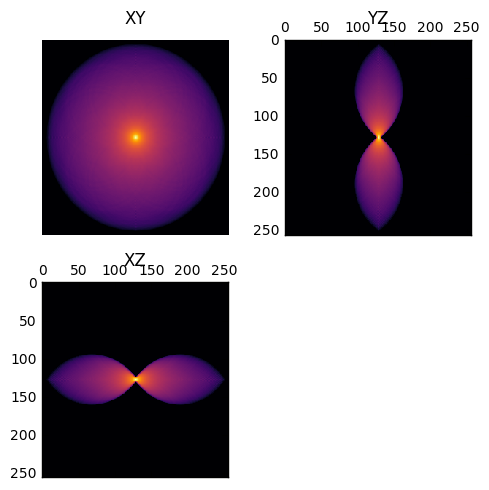

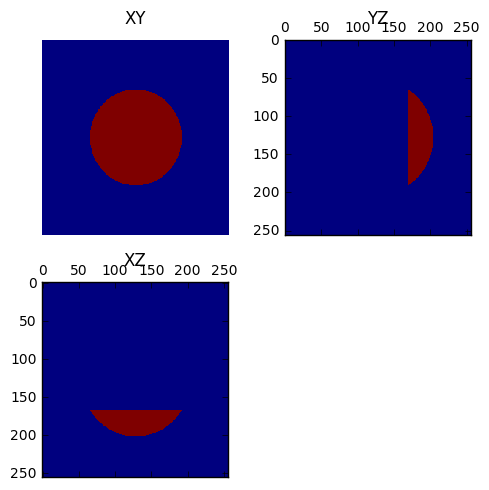

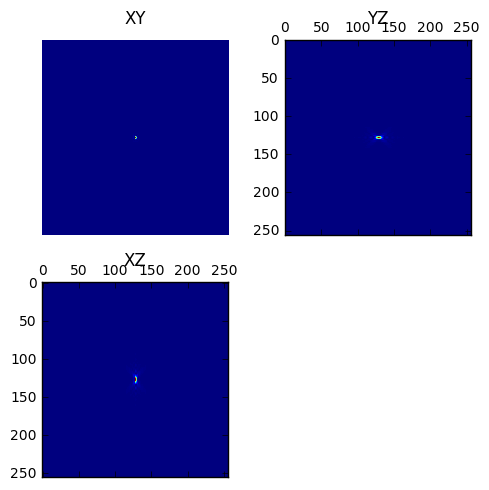

In [13]:
# with np.errstate(invalid="raise"):
# psf_shep.vec_corr = "total"
slice_plot(log(scale(abs(psf_shep.OTFi))), vmin = -6, cmap="inferno")
mip((psf_shep.OTFa[0]))
slice_plot(psf_shep.PSFi)

True


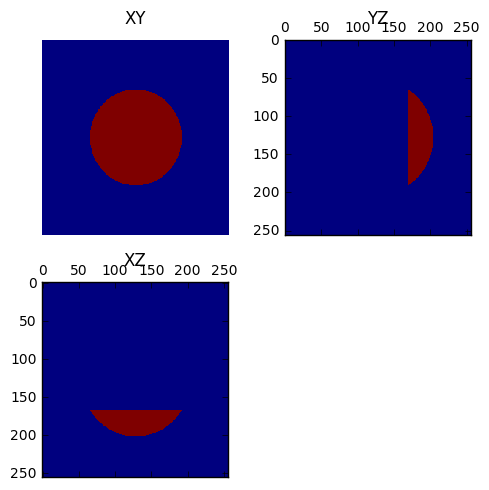

In [14]:
for o in psf_shep.OTFa:
    print(isfinite(o).all())
    mip(o)

In [15]:
# comparison
args = (488, 0.85, 1.0, 140, 256)
kwargs = dict(vec_corr="total")
psf = [HanserPSF(*args, **kwargs), SheppardPSF(*args, **kwargs)]
for p in psf:
    print(p.__class__)
    %timeit -r1 -n1 p.OTFi, p.OTFa, p.PSFi, p.PSFa

<class '__main__.HanserPSF'>
1 loop, best of 1: 21.9 s per loop
<class '__main__.SheppardPSF'>
1 loop, best of 1: 15.5 s per loop


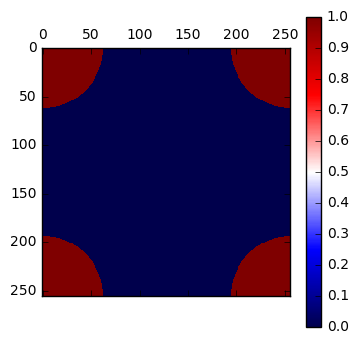

In [37]:
matshow(psf[0]._gen_pupil().real, cmap="seismic")
colorbar()

(<matplotlib.figure.Figure at 0x20b816f5e80>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020B815584A8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000020B81906940>], dtype=object))

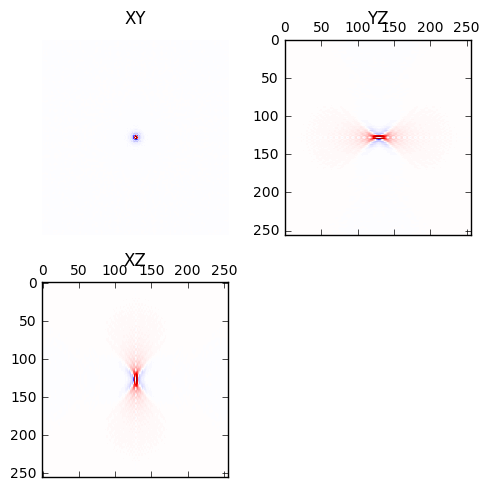

In [30]:
scaled_diff = (scale(psf[0].PSFi) - scale(psf[1].PSFi))
slice_plot(scaled_diff, cmap="seismic", vmin=-4e-2, vmax=4e-2)

0.657201816374


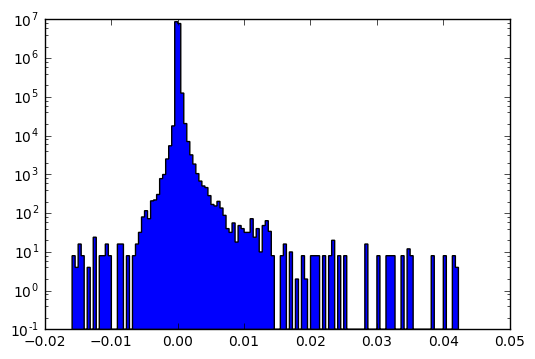

In [17]:
print((scaled_diff ** 2).sum())
hist(scaled_diff.ravel(), log=True, bins=128, histtype="stepfilled");

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


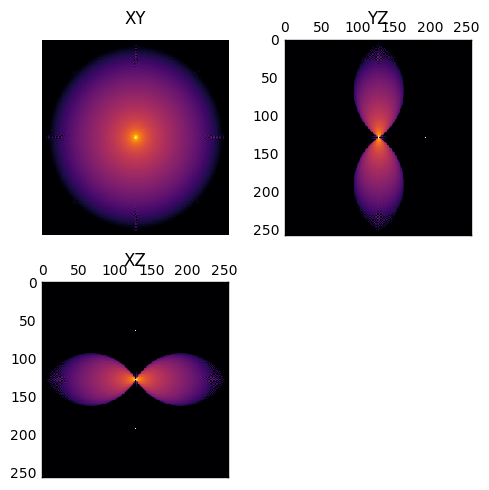

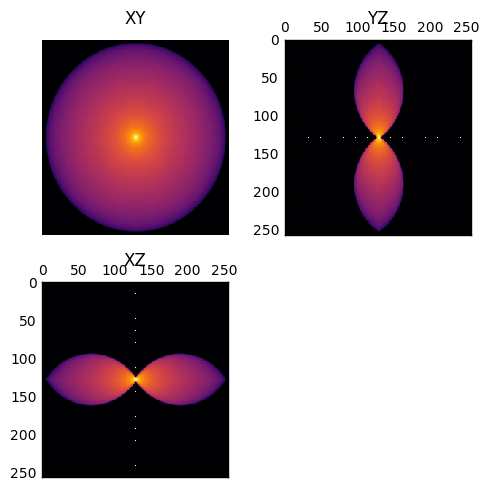

In [26]:
for p in psf:
    slice_plot(log(scale(abs(p.OTFi))), vmin = -8,cmap="inferno")

In [18]:
# need to test using different x and z resolutions for sheppard psf, need to add vectorial corrections and need
# to add wavelength dispersion.

In [19]:
from scipy.ndimage import label

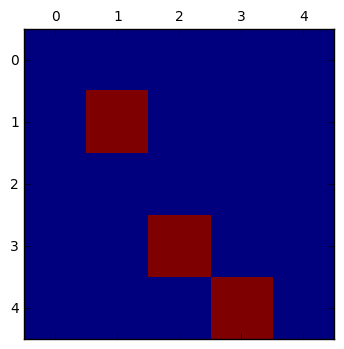

In [20]:
test_data = np.array([
        [0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
    ])

matshow(test_data)

In [21]:
label(test_data, structure=ones((3,3)))

(array([[0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 2, 0, 0],
        [0, 0, 0, 2, 0]]), 2)

In [22]:
label(psf_shep.OTFa, structure=ones((3, 3, 3)))

RuntimeError: structure and input must have equal rank

Use [`numpy.dtype.kind`](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.dtype.kind.html) for type checking of numerics

[Snippet](https://github.com/numpy/numpy/blob/v1.11.0/numpy/lib/arraypad.py#L1117-L1494) showing how to validate kwargs:
```python
    allowedkwargs = {
        'constant': ['constant_values'],
        'edge': [],
        'linear_ramp': ['end_values'],
        'maximum': ['stat_length'],
        'mean': ['stat_length'],
        'median': ['stat_length'],
        'minimum': ['stat_length'],
        'reflect': ['reflect_type'],
        'symmetric': ['reflect_type'],
        'wrap': [],
        }

    kwdefaults = {
        'stat_length': None,
        'constant_values': 0,
        'end_values': 0,
        'reflect_type': 'even',
        }

    if isinstance(mode, np.compat.basestring):
        # Make sure have allowed kwargs appropriate for mode
        for key in kwargs:
            if key not in allowedkwargs[mode]:
                raise ValueError('%s keyword not in allowed keywords %s' %
                                 (key, allowedkwargs[mode]))

        # Set kwarg defaults
        for kw in allowedkwargs[mode]:
            kwargs.setdefault(kw, kwdefaults[kw])

        # Need to only normalize particular keywords.
        for i in kwargs:
            if i == 'stat_length':
                kwargs[i] = _validate_lengths(narray, kwargs[i])
            if i in ['end_values', 'constant_values']:
                kwargs[i] = _normalize_shape(narray, kwargs[i],
                                             cast_to_int=False)
```
